## Colab Init

In [ ]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    drive.mount("/content/drive/")
    %cd ./drive/MyDrive/Projekte/tsf/

IN_COLAB

## Modules

In [2]:
import src
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

from torch.utils.data import DataLoader

importlib.reload(src)

<module 'src' from '/Users/alex/Projekte/tcn/src/__init__.py'>

## Settings

In [3]:
LOOKING_BACK_WINDOW = 48
FORECAST_HORIZON = 24
BATCH_SIZE = 64
DEV_SIZE = 0.1
LR = 0.001
DROPOUT = 0
HIDDEN_CHANNELS_FACTOR = 1

## Data

In [4]:
def get_ett():
    df = pd.read_csv("./data/ETTh1.csv", parse_dates=["date"])
    df.index = df["date"]
    df.index.name = "t"
    df = df.drop(["date"], axis=1)
    df = df[["OT"]]
    df["OT"] = (df["OT"]-df["OT"].mean())/df["OT"].std()
    split_idx = int(len(df)*0.9)
    df_train, df_dev = df[:split_idx], df[split_idx:]
    df_train.shape, df_dev.shape

    dataset = {
    "train": src.Timeseries(df_train, "OT", looking_back_window=LOOKING_BACK_WINDOW, forecast_horizon=FORECAST_HORIZON),
    "dev": src.Timeseries(df_dev, "OT", looking_back_window=LOOKING_BACK_WINDOW, forecast_horizon=FORECAST_HORIZON)
    }
    data_loader = {
        "train": DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
        "dev": DataLoader(dataset["dev"], batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    }

    return dataset, data_loader


dataset, data_loader = get_ett()
len(dataset), len(data_loader)

(2, 2)

## Model

In [5]:
net = src.TCN( 
    LOOKING_BACK_WINDOW,
    FORECAST_HORIZON,
    dataset["train"].features, 
    dropout=DROPOUT,
    hidden_channels_factor=HIDDEN_CHANNELS_FACTOR
)
print(net.amount_parameters)
print(net)

11092
TCN(
  (m): Sequential(
    (0): ResidualBlock(
      (res): Conv1d(1, 24, kernel_size=(1,), stride=(1,))
      (m): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(1, 24, kernel_size=(3,), stride=(1,))
        (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Dropout(p=0, inplace=False)
        (5): ConstantPad1d(padding=(2, 0), value=0)
        (6): Conv1d(24, 24, kernel_size=(3,), stride=(1,))
        (7): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Dropout(p=0, inplace=False)
      )
    )
    (1): ResidualBlock(
      (m): Sequential(
        (0): ConstantPad1d(padding=(4, 0), value=0)
        (1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), dilation=(2,))
        (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Dropout(p=0, inplace=Fa

## Training

In [6]:
trainer = src.Trainer()
trainer.fit(net, data_loader, epochs=100, lr=LR)

(1) train 	 l1=0.31
(1) dev 	 l1=0.20
(2) train 	 l1=0.29
(2) dev 	 l1=0.19
(3) train 	 l1=0.29
(3) dev 	 l1=0.18
(4) train 	 l1=0.28
(4) dev 	 l1=0.17
(5) train 	 l1=0.28
(5) dev 	 l1=0.17
(6) train 	 l1=0.27
(6) dev 	 l1=0.19
(7) train 	 l1=0.26
(7) dev 	 l1=0.20
(8) train 	 l1=0.26
(8) dev 	 l1=0.23
(9) train 	 l1=0.26
(9) dev 	 l1=0.21
(10) train 	 l1=0.25
(10) dev 	 l1=0.18
(11) train 	 l1=0.25
(11) dev 	 l1=0.18
(12) train 	 l1=0.25
(12) dev 	 l1=0.20
(13) train 	 l1=0.24
(13) dev 	 l1=0.20
(14) train 	 l1=0.24
(14) dev 	 l1=0.22
(15) train 	 l1=0.24
(15) dev 	 l1=0.22
(16) train 	 l1=0.23
(16) dev 	 l1=0.23
(17) train 	 l1=0.23
(17) dev 	 l1=0.24
(18) train 	 l1=0.22
(18) dev 	 l1=0.22
(19) train 	 l1=0.22
(19) dev 	 l1=0.24
(20) train 	 l1=0.21
(20) dev 	 l1=0.23
(21) train 	 l1=0.21
(21) dev 	 l1=0.28
(22) train 	 l1=0.21
(22) dev 	 l1=0.22
(23) train 	 l1=0.20
(23) dev 	 l1=0.23
(24) train 	 l1=0.20
(24) dev 	 l1=0.27
(25) train 	 l1=0.19
(25) dev 	 l1=0.22
(26) train 	 l1=0.

## Predicting

In [7]:
all_inputs, all_targets, all_outputs, y_true, y_pred = trainer.predict(net, data_loader)
len(all_inputs), len(all_targets), len(all_outputs), len(y_true), len(y_pred)

(27, 27, 27, 1671, 1671)

## Visualization

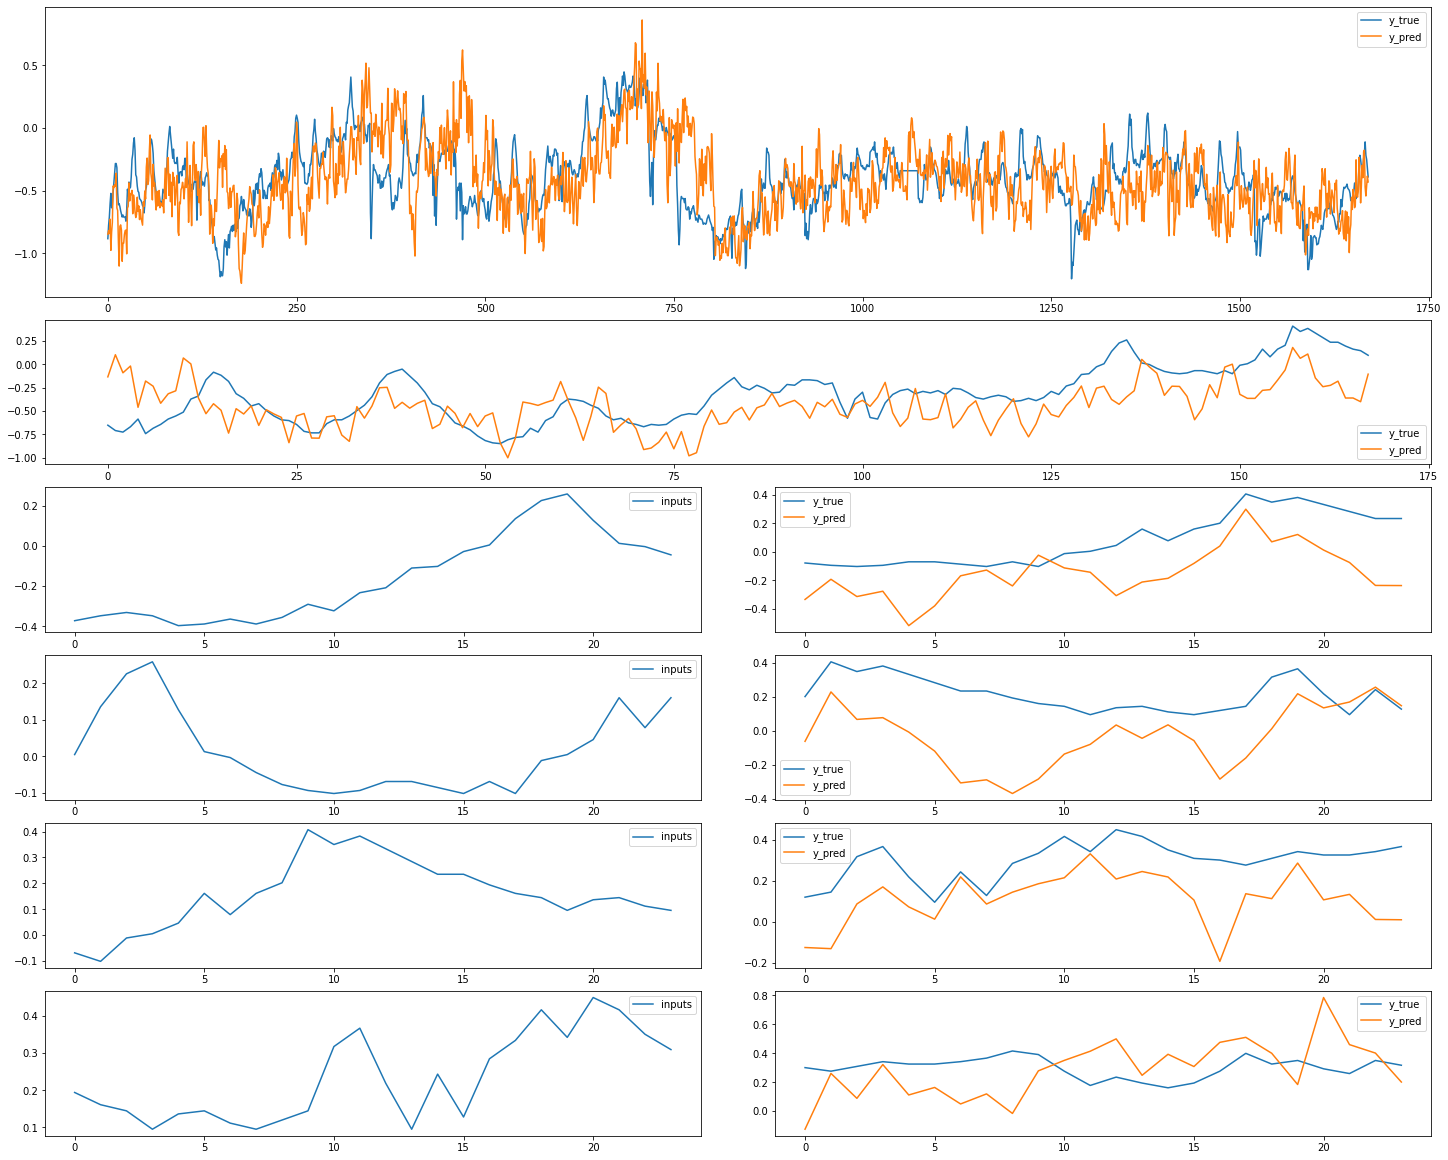

In [8]:
zoom_idx, zoom_size = 500, 24*7

examples = []
random_idx = random.randrange(len(all_inputs))
random_inputs = all_inputs[random_idx]
random_targets = all_targets[random_idx]
random_outputs = all_outputs[random_idx]

for i in range(0, 64, 16):
    examples.append((
        np.array(random_inputs[i]).reshape(-1)[-FORECAST_HORIZON:],
        np.array(random_targets[i]),
        np.array(random_outputs[i])
    ))

fig = plt.figure(constrained_layout=True, figsize=(20, 16))
gs = fig.add_gridspec(7, 2)

ax1 = fig.add_subplot(gs[:2, :])
ax1.plot(y_true, label="y_true")
ax1.plot(y_pred, label="y_pred")
ax1.legend()

ax2 = fig.add_subplot(gs[2, :])
ax2.plot(y_true[zoom_idx:zoom_idx+zoom_size], label="y_true")
ax2.plot(y_pred[zoom_idx:zoom_idx+zoom_size], label="y_pred")
ax2.legend()

ax31 = fig.add_subplot(gs[3, 0])
ax31.plot(examples[0][0], label="inputs")
ax31.legend()

ax32 = fig.add_subplot(gs[3, 1])
ax32.plot(examples[0][1], label="y_true")
ax32.plot(examples[0][2], label="y_pred")
ax32.legend()

ax41 = fig.add_subplot(gs[4, 0])
ax41.plot(examples[1][0], label="inputs")
ax41.legend()

ax42 = fig.add_subplot(gs[4, 1])
ax42.plot(examples[1][1], label="y_true")
ax42.plot(examples[1][2], label="y_pred")
ax42.legend()

ax51 = fig.add_subplot(gs[5, 0])
ax51.plot(examples[2][0], label="inputs")
ax51.legend()

ax52 = fig.add_subplot(gs[5, 1])
ax52.plot(examples[2][1], label="y_true")
ax52.plot(examples[2][2], label="y_pred")
ax52.legend()

ax61 = fig.add_subplot(gs[6, 0])
ax61.plot(examples[3][0], label="inputs")
ax61.legend()

ax62 = fig.add_subplot(gs[6, 1])
ax62.plot(examples[3][1], label="y_true")
ax62.plot(examples[3][2], label="y_pred")
ax62.legend()